In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Use the actual notebook working directory
nb_dir = Path.cwd()
print(f"Current notebook path: {nb_dir}")

# Optionally add the notebook dir (for local-only imports)
if str(nb_dir) not in sys.path:
    sys.path.insert(0, str(nb_dir))
    print(f"Added {nb_dir} to sys.path")

# Critically: add the repository root so top-level packages like 'utils' are importable
# Notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration
# Repo root is two levels up: /home/luky/skola/KalmanNet-main
repo_root = nb_dir.parents[1]
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    print(f"Added {repo_root} to sys.path")

Current notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration copy
Added /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration copy to sys.path
Added /home/luky/skola/KalmanNet-main to sys.path


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


Načítám data z: ../preprocessed_NCLT_trajectory-2012-01-22...
✅ Data úspěšně načtena.
  -> Celkový počet vzorků: 5208
  -> Input Shape (Měření): torch.Size([5208, 4]) ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]
  -> Target Shape (GT):    torch.Size([5208, 4]) ... [PX, VX, PY, VY]


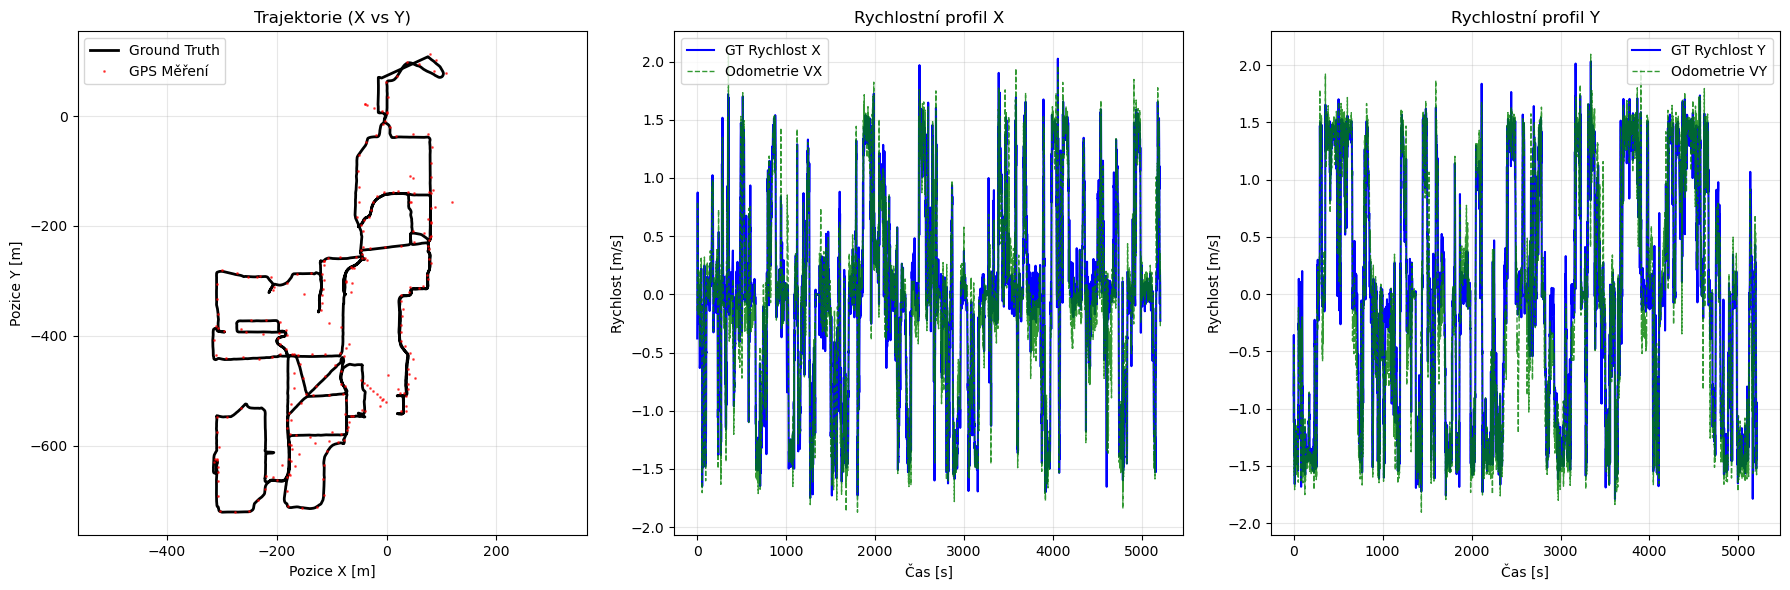

In [3]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np

# === 1. KONFIGURACE ===
# Cesta k adresáři, který vytvořil preprocess skript
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22'

print(f"Načítám data z: {data_dir}...")

try:
    # === 2. NAČTENÍ DAT (.pt soubory) ===
    # Data jsou uložena jako list slovníků [{'ground_truth': ..., 'filtered_gps': ...}]
    # filtered_gps zde ale obsahuje náš 4D vektor [GPS_X, ODO_VX, GPS_Y, ODO_VY]
    
    train_data = torch.load(os.path.join(data_dir, 'train.pt'))
    val_data = torch.load(os.path.join(data_dir, 'val.pt'))
    test_data = torch.load(os.path.join(data_dir, 'test.pt'))

    # Extrakce tensorů (předpokládáme 1 trajektorii v listu)
    X_train, Y_train = train_data[0]['ground_truth'], train_data[0]['filtered_gps']
    X_val, Y_val     = val_data[0]['ground_truth'],   val_data[0]['filtered_gps']
    X_test, Y_test   = test_data[0]['ground_truth'],  test_data[0]['filtered_gps']

    # Spojení zpět do jedné sekvence pro vizualizaci celé trajektorie
    X_full = torch.cat([X_train, X_val, X_test], dim=0)
    Y_full = torch.cat([Y_train, Y_val, Y_test], dim=0)

    print(f"✅ Data úspěšně načtena.")
    print(f"  -> Celkový počet vzorků: {X_full.shape[0]}")
    print(f"  -> Input Shape (Měření): {Y_full.shape} ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]")
    print(f"  -> Target Shape (GT):    {X_full.shape} ... [PX, VX, PY, VY]")

    # === 3. VIZUALIZACE ===
    # Převedeme na numpy pro matplotlib
    gt_np = X_full.numpy()
    meas_np = Y_full.numpy()
    time_steps = np.arange(len(gt_np)) # Předpoklad 1Hz (DT=1.0)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # --- A) Trajektorie (X-Y) ---
    # Ground Truth (Sloupce 0 a 2 v Targetu)
    ax[0].plot(gt_np[:, 0], gt_np[:, 2], 'k-', linewidth=2, label='Ground Truth')
    
    # GPS Měření (Sloupce 0 a 2 v Inputu)
    # Vykreslíme jen každý 20. bod, aby graf nebyl přeplácaný
    ax[0].plot(meas_np[::20, 0], meas_np[::20, 2], 'r.', markersize=2, alpha=0.6, label='GPS Měření')

    ax[0].set_title('Trajektorie (X vs Y)')
    ax[0].set_xlabel('Pozice X [m]')
    ax[0].set_ylabel('Pozice Y [m]')
    ax[0].axis('equal')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # --- B) Rychlost X (VX) ---
    # GT Rychlost (Sloupec 1 v Targetu)
    ax[1].plot(time_steps, gt_np[:, 1], 'b-', linewidth=1.5, label='GT Rychlost X')
    # ODO Rychlost (Sloupec 1 v Inputu)
    ax[1].plot(time_steps, meas_np[:, 1], 'g--', linewidth=1, alpha=0.8, label='Odometrie VX')

    ax[1].set_title('Rychlostní profil X')
    ax[1].set_xlabel('Čas [s]')
    ax[1].set_ylabel('Rychlost [m/s]')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # --- C) Rychlost Y (VY) ---
    # GT Rychlost (Sloupec 3 v Targetu)
    ax[2].plot(time_steps, gt_np[:, 3], 'b-', linewidth=1.5, label='GT Rychlost Y')
    # ODO Rychlost (Sloupec 3 v Inputu)
    ax[2].plot(time_steps, meas_np[:, 3], 'g--', linewidth=1, alpha=0.8, label='Odometrie VY')

    ax[2].set_title('Rychlostní profil Y')
    ax[2].set_xlabel('Čas [s]')
    ax[2].set_ylabel('Rychlost [m/s]')
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ CHYBA: Adresář '{data_dir}' nebo soubory .pt nenalezeny.")
    print("Spustil jsi předtím skript 'preprocess_NCLT_trajectory_linear_test.py'?")
except Exception as e:
    print(f"❌ CHYBA: {e}")

Načítám data pro vizualizaci z: ../preprocessed_NCLT_trajectory-2012-01-22...


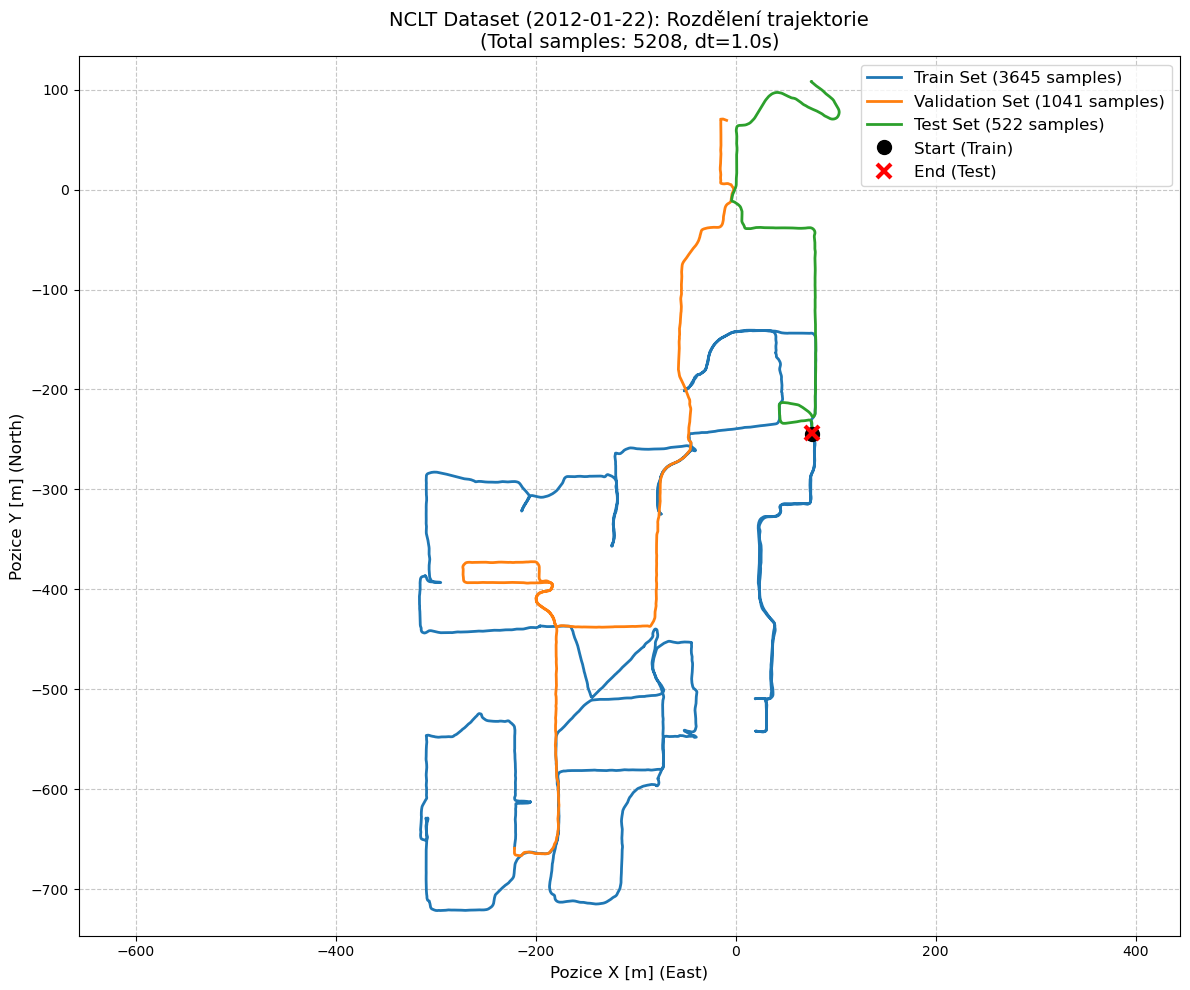

In [4]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np

# === 1. NAČTENÍ DAT ===
# Cesta k adresáři s daty (musí odpovídat výstupu předchozího skriptu)
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22'

print(f"Načítám data pro vizualizaci z: {data_dir}...")

# Načtení listů (formát [{'ground_truth': ..., 'filtered_gps': ...}])
train_list = torch.load(os.path.join(data_dir, 'train.pt'))
val_list = torch.load(os.path.join(data_dir, 'val.pt'))
test_list = torch.load(os.path.join(data_dir, 'test.pt'))

# Extrakce Ground Truth tensorů (předpokládáme 1 souvislou trajektorii v indexu 0)
# GT formát: [px, vx, py, vy] -> X je index 0, Y je index 2
train_target = train_list[0]['ground_truth']
val_target   = val_list[0]['ground_truth']
test_target  = test_list[0]['ground_truth']

# Spočítáme celkový počet vzorků pro titulek
N_samples = len(train_target) + len(val_target) + len(test_target)
DT = 1.0 # Víme z konfigurace

# === 2. VIZUALIZACE ROZDĚLENÍ DATASETU ===

plt.figure(figsize=(12, 10))

# 1. Vykreslení Trénovací části (85%)
plt.plot(train_target[:, 0].numpy(), 
         train_target[:, 2].numpy(), 
         label=f'Train Set ({len(train_target)} samples)', color='#1f77b4', linewidth=2)

# 2. Vykreslení Validační části (10%)
plt.plot(val_target[:, 0].numpy(), 
         val_target[:, 2].numpy(), 
         label=f'Validation Set ({len(val_target)} samples)', color='#ff7f0e', linewidth=2)

# 3. Vykreslení Testovací části (5%)
plt.plot(test_target[:, 0].numpy(), 
         test_target[:, 2].numpy(), 
         label=f'Test Set ({len(test_target)} samples)', color='#2ca02c', linewidth=2)

# Zvýraznění začátku a konce
# Start (začátek tréninku)
plt.plot(train_target[0, 0], train_target[0, 2], 'ko', markersize=10, label='Start (Train)')
# End (konec testu)
plt.plot(test_target[-1, 0], test_target[-1, 2], 'rx', markersize=10, markeredgewidth=3, label='End (Test)')

# Formátování grafu
plt.title(f'NCLT Dataset (2012-01-22): Rozdělení trajektorie\n(Total samples: {N_samples}, dt={DT}s)', fontsize=14)
plt.xlabel('Pozice X [m] (East)', fontsize=12)
plt.ylabel('Pozice Y [m] (North)', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Důležité: Aby mapa nebyla deformovaná

plt.tight_layout()
plt.show()

# Model definition

In [5]:
import torch
import math
import Systems # Tvůj modul s třídou DynamicSystem

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###################################################################
### Design Parameters - REAL SENSOR FUSION (NCLT Dataset)       ###
### Cíl: Fúze reálné GPS a Odometrie s optimálními parametry    ###
###################################################################

# 1. Rozměry
# Stav: [px, vx, py, vy] (Globální souřadnice)
m = 4 
n = 4 
delta_t = 1.0 # Sampling (1 Hz)

# 2. Dynamika (F) - Constant Velocity Model (Newton)
# x_{t+1} = x_t + v_t * dt
# v_{t+1} = v_t
F_dim = torch.tensor([[1.0, delta_t],
                      [0.0, 1.0]])

# Blokově diagonální pro X a Y: [[F, 0], [0, F]]
F_design = torch.block_diag(F_dim, F_dim).float()

# 3. Měření (H) - Identita
# Nyní měříme VŠECHNY stavy přímo:
# y = [gps_px, odo_vx, gps_py, odo_vy]
H_design = torch.eye(n).float()

# 4. Šum procesu (Q) - Fyzikální model
# Používáme "Discretized Continuous White Noise Acceleration" model.
# -------------------------------------------------------------------
# OPTIMALIZOVANÁ HODNOTA Z NCLT DAT (2012-01-22):
q_scale = 0.006697 
# -------------------------------------------------------------------

# Blok Q pro jednu dimenzi (pozice, rychlost)
Q_block = torch.tensor([[delta_t**3/3, delta_t**2/2],
                        [delta_t**2/2, delta_t]]) * q_scale

Q_design = torch.block_diag(Q_block, Q_block).float()

# 5. Šum měření (R) - Statistika z dat (Oracle)
# -------------------------------------------------------------------
# HODNOTY VYPOČTENÉ Z REZIDUÍ (Var = Std^2):
var_gps = 93.8867  # Odpovídá chybě cca 9.7 metrů
var_odo = 0.0440   # Odpovídá chybě cca 0.21 m/s
# -------------------------------------------------------------------

R_design = torch.tensor([[var_gps, 0.0,     0.0,     0.0],
                         [0.0,     var_odo, 0.0,     0.0],
                         [0.0,     0.0,     var_gps, 0.0],
                         [0.0,     0.0,     0.0,     var_odo]]).float()

# 6. Počáteční podmínky
# Inicializujeme na nule s rozumnou nejistotou
m1x_0 = torch.zeros(m, 1).float()
m2x_0 = torch.eye(m).float() * 10.0 # Větší nejistota na začátku (nevíme přesně kde jsme)

print("\nInicializuji systém pro REÁLNOU SENZORICKOU FÚZI (NCLT)...")
print(f"Dimenze stavu: {m}, Dimenze měření: {n}")
print(f"Použité Q scale: {q_scale}")
print(f"Použité R (diag): {torch.diagonal(R_design).numpy()}")

# === INICIALIZACE SYSTÉMŮ ===

# Sys True (V tomto reálném scénáři 'Sys True' neexistuje v generativním smyslu,
# protože data nepochází z tohoto modelu, ale z reality. Nicméně pro kompatibilitu
# s architekturou KalmanNetu ho definujeme stejně jako Model).
sys_true = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

# Sys Model (To, co používá filtr pro odhad)
sys_model = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

print("... Systémy inicializovány.")
print("Model je připraven na vstup: [GPS_X, ODO_VX, GPS_Y, ODO_VY]")


Inicializuji systém pro REÁLNOU SENZORICKOU FÚZI (NCLT)...
Dimenze stavu: 4, Dimenze měření: 4
Použité Q scale: 0.006697
Použité R (diag): [9.38867e+01 4.40000e-02 9.38867e+01 4.40000e-02]
... Systémy inicializovány.
Model je připraven na vstup: [GPS_X, ODO_VX, GPS_Y, ODO_VY]


In [6]:
import torch
import os
from torch.utils.data import TensorDataset, DataLoader

# === 0. NAČTENÍ PŘEDZPRACOVANÝCH DAT ===
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22-angle-update' # Uprav cestu dle potřeby
print(f"Načítám data z: {data_dir}...")

try:
    train_list = torch.load(os.path.join(data_dir, 'train.pt'))
    val_list = torch.load(os.path.join(data_dir, 'val.pt'))
    test_list = torch.load(os.path.join(data_dir, 'test.pt'))

    # Extrakce tensorů
    train_target = train_list[0]['ground_truth'].float()
    val_target   = val_list[0]['ground_truth'].float()
    test_target  = test_list[0]['ground_truth'].float()

    train_input  = train_list[0]['filtered_gps'].float()
    val_input    = val_list[0]['filtered_gps'].float()
    test_input   = test_list[0]['filtered_gps'].float()

    print(f"Data načtena. Train: {len(train_target)}, Val: {len(val_target)}, Test: {len(test_target)}")

except FileNotFoundError:
    raise FileNotFoundError(f"Chybí data v {data_dir}.")

# === 1. KONFIGURACE ===
# Zde je ta změna:
TRAIN_SEQ_LEN = 50      # Krátké pro rychlý backprop
VAL_SEQ_LEN = 200       # Střední pro stabilní validaci (místo celé délky)
TEST_SEQ_LEN = len(test_target) # Test necháme celý pro finální "pravdu"

STRIDE_TRAIN = 3        # Překryv u tréninku (Data Augmentation)
STRIDE_VAL = 20        # Bez překryvu u validace (chceme nezávislé úseky)

BATCH_SIZE = 64


def create_sequences(X, Y, seq_len, stride=1):
    """
    Rozseká dlouhé tenzory na sekvence.
    """
    xs = []
    ys = []
    num_samples = X.shape[0]
    
    # Pokud je požadovaná délka delší než data, vrátíme co máme (pro Test)
    if seq_len >= num_samples:
        return X.unsqueeze(0), Y.unsqueeze(0)
    
    # Sekání
    for i in range(0, num_samples - seq_len + 1, stride):
        x_seq = X[i : i+seq_len, :]
        y_seq = Y[i : i+seq_len, :]
        xs.append(x_seq)
        ys.append(y_seq)
        
    if len(xs) == 0:
        return torch.empty(0, seq_len, X.shape[1]), torch.empty(0, seq_len, Y.shape[1])
        
    return torch.stack(xs), torch.stack(ys)

def clean_sequences(X_seq, Y_seq, name="Dataset"):
    if X_seq.numel() == 0:
        print(f"⚠️ {name}: Prázdný vstup!")
        return X_seq, Y_seq

    # Kontrola NaN/Inf
    is_nan_x = torch.isnan(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_inf_x = torch.isinf(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_nan_y = torch.isnan(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    is_inf_y = torch.isinf(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    
    invalid_mask = is_nan_x | is_inf_x | is_nan_y | is_inf_y
    valid_mask = ~invalid_mask
    
    X_clean = X_seq[valid_mask]
    Y_clean = Y_seq[valid_mask]
    
    n_dropped = invalid_mask.sum().item()
    if n_dropped > 0:
        print(f"⚠️ {name}: Odstraněno {n_dropped} vadných sekvencí.")
    else:
        print(f"✅ {name}: Data jsou čistá. ({len(X_clean)} sekvencí)")
        
    return X_clean, Y_clean

print("\n--- ZPRACOVÁNÍ SEKVENCÍ ---")

# === 2. TVORBA SEKVENCÍ ===
print(f"Generuji TRAIN sekvence (Len={TRAIN_SEQ_LEN}, Stride={STRIDE_TRAIN})...")
train_X_raw, train_Y_raw = create_sequences(train_target, train_input, TRAIN_SEQ_LEN, STRIDE_TRAIN)

# ZMĚNA: Validace už není jedna dlouhá nudle, ale sada 1000-krokových úseků
print(f"Generuji VAL sekvence (Len={VAL_SEQ_LEN}, Stride={STRIDE_VAL})...")
val_X_raw, val_Y_raw = create_sequences(val_target, val_input, VAL_SEQ_LEN, STRIDE_VAL)

print(f"Generuji TEST sekvence (Full trajectory)...")
test_X_raw, test_Y_raw = create_sequences(test_target, test_input, TEST_SEQ_LEN, TEST_SEQ_LEN)

# === 3. ČIŠTĚNÍ DAT ===
train_X_seq, train_Y_seq = clean_sequences(train_X_raw, train_Y_raw, "Train")
val_X_seq, val_Y_seq = clean_sequences(val_X_raw, val_Y_raw, "Val")
test_X_seq, test_Y_seq = clean_sequences(test_X_raw, test_Y_raw, "Test")

# === 4. VYTVOŘENÍ DATALOADERŮ ===
print("\nVytvářím DataLoadery...")

train_dataset = TensorDataset(train_X_seq, train_Y_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val: Batch size může být nyní větší než 1, protože máme více sekvencí stejné délky!
# To zrychlí validaci.
val_dataset = TensorDataset(val_X_seq, val_Y_seq)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(test_X_seq, test_Y_seq)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"\n✅ HOTOVO.")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)} (Délka každé sekvence: {VAL_SEQ_LEN})")
print(f"Test samples:  {len(test_dataset)} (Celá trajektorie)")

Načítám data z: ../preprocessed_NCLT_trajectory-2012-01-22-angle-update...
Data načtena. Train: 3645, Val: 1041, Test: 522

--- ZPRACOVÁNÍ SEKVENCÍ ---
Generuji TRAIN sekvence (Len=50, Stride=3)...
Generuji VAL sekvence (Len=200, Stride=20)...
Generuji TEST sekvence (Full trajectory)...
✅ Train: Data jsou čistá. (1199 sekvencí)
✅ Val: Data jsou čistá. (43 sekvencí)
✅ Test: Data jsou čistá. (1 sekvencí)

Vytvářím DataLoadery...

✅ HOTOVO.
Train samples: 1199
Val samples:   43 (Délka každé sekvence: 200)
Test samples:  1 (Celá trajektorie)


In [7]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
from state_NN_models import StateKalmanNet

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
import torch
import torch.optim as optim
import os
from state_NN_models import StateKalmanNet
from utils import trainer

state_knet = StateKalmanNet(
    system_model=sys_model,
    device=device,
    hidden_size_multiplier=8,      # Větší kapacita pro složitější dynamiku
    output_layer_multiplier=4,
    num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
    gru_hidden_dim_multiplier=6,
    returns_covariance=True

).to(device)
print(state_knet)

# Počet trénovatelných parametrů
params_count = sum(p.numel() for p in state_knet.parameters() if p.requires_grad)
print(f"Model má {params_count} trénovatelných parametrů.")

# === 2. NASTAVENÍ TRÉNINKU (TBPTT) ===

# Parametry pro Sliding Window trénink (TBPTT)
# NCLT sekvence jsou dlouhé (100 kroků), gradienty by mohly explodovat.
# Dělíme je na okna délky 20 a gradienty ořezáváme.
TBPTT_WINDOW = 4  # Délka okna (w)
TBPTT_STEP = 2    # Krok pro detach (k) - obvykle polovina w

EPOCHS =200
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3 # Jemná regularizace
CLIP_GRAD = 1.0    # Důležité: Ořezání gradientů pro stabilitu RNN

# === 3. SPUŠTĚNÍ TRÉNINKU ===
print("\n🚀 Spouštím tréninkovou smyčku...")

# trained_knet = trainer.train_state_KalmanNet_sliding_window(
#     model=state_knet,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     epochs=EPOCHS,
#     lr=LEARNING_RATE,
#     weight_decay_=WEIGHT_DECAY,
#     clip_grad=CLIP_GRAD,
#     early_stopping_patience=30, # Zastaví, pokud se 30 epoch nezlepší loss
#     tbptt_k=TBPTT_STEP,
#     tbptt_w=TBPTT_WINDOW,
#     optimizer_=optim.AdamW,
# )
trained_knet = trainer.train_state_KalmanNet(
    model=state_knet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    clip_grad=CLIP_GRAD,
    early_stopping_patience=30, # Zastaví, pokud se 30 epoch nezlepší loss
    optimizer_type=optim.AdamW,
)

# # === 4. ULOŽENÍ MODELU ===
# save_path = 'best_kalmannet_nclt_sensor_fusion.pth'
# torch.save(trained_knet_.state_dict(), save_path)
# print(f"\n✅ Trénink dokončen. Nejlepší model uložen do: {save_path}")

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=384, bias=True)
      (1): ReLU()
    )
    (gru): GRU(384, 64)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
    )
  )
)
Model má 98128 trénovatelných parametrů.

🚀 Spouštím tréninkovou smyčku...
New best model saved! Epoch [1/200], Train Loss: 430.210279, Val Loss: 242.050674
Epoch [5/200] | Train Loss: 122.3784 (Pos: 0.00, Vel: 0.00) | Val Loss: 1758.4890 | Val MSE: 1758.49
Epoch [1/200], Train Loss: 430.210279, Val Loss: 242.050674, Avg Cov Trace: 58.557742
Epoch [10/200] | Train Loss: 87.7902 (Pos: 0.00, Vel: 0.00) | Val Loss: 419.7465 | Val MSE: 419.75
Epoch [1/200], Train Loss: 430.210279, Val Loss: 242.050674, Avg 

In [ ]:
if False:
    import torch
    import os

    # Protože jsi trénink přerušil, nemáme slovník s metrikami automaticky.
    # Musíme uložit přímo model 'state_knet'.

    # 1. Definuj cestu (Metriky si do názvu musíš dopsat ručně podle toho, co jsi viděl v logu naposledy,
    # nebo použij obecný název, abys o model nepřišel).
    save_path = 'KalmanNet_test.pth'

    # Pokud si pamatuješ hodnoty z logu (např. ANEES 23.5), můžeš je tam dopsat ručně:
    # save_path = 'best_kalmannet_nclt_sensor_fusion_ANEES23.57_MSE8.17_interrupted.pth'

    # 2. Uložení
    # DŮLEŽITÉ: Voláme .state_dict() přímo na objektu state_knet (nebo trained_knet, pokud jsi ho přiřadil)
    # Nepoužíváme závorky ['final_model'], protože state_knet UŽ JE ten model.
    torch.save(state_knet.state_dict(), save_path)

    print(f"\n✅ Záchrana modelu úspěšná! Uloženo do: {save_path}")

if False:
    import os
    # trained_knet = state_knet 
    # Přístup k metrikám ve slovníku je správně (přes závorky [])
    print(f"   -> Best ANEES: {trained_knet['best_val_anees']:.4f}")
    print(f"   -> Best MSE:   {trained_knet['best_val_mse']:.4f}")
    save_path = f'best_kalmanFormer_nclt_sensor_fusion_ANEES{trained_knet["best_val_anees"]:.4f}_MSE{trained_knet["best_val_mse"]:.4f}_nejlepsi_test_vysledky.pth '

    # OPRAVA: Musíš vytáhnout model ze slovníku pomocí klíče 'final_model'
    # A teprve na něm zavolat .state_dict()
    torch.save(trained_knet['final_model'].state_dict(), save_path)

    print(f"\n✅ Model úspěšně uložen do: {save_path}")


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import Filters  # Předpokládám, že máš tento modul
from utils import utils # Předpokládám, že máš utils pro výpočet ANEES

# ==============================================================================
# 0. KONFIGURACE A PŘÍPRAVA MODELŮ
# ==============================================================================
# Přiřadíme tvůj natrénovaný model
try:
    trained_model_classic = state_knet
    trained_model_classic.eval()
    
    # DŮLEŽITÉ: Zapneme vracení kovariance pro vyhodnocení ANEES
    trained_model_classic.returns_covariance = True 
    
    print("INFO: KalmanNet (state_knet) připraven k testování (včetně Covariance).")
except NameError:
    raise NameError("Chyba: Proměnná 'state_knet' neexistuje. Spusťte nejprve trénink.")

# Inicializace klasických filtrů
# Používáme 'sys_model', který obsahuje parametry (Q, R atd.)
print("Inicializuji EKF a UKF...")
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
ukf_filter = Filters.UnscentedKalmanFilter(sys_model)
pf_filter = Filters.ParticleFilter(sys_model, num_particles=10000)
akf_filter = Filters.AdaptiveKalmanFilter(sys_model,mdm_L=4,mdm_version=1)
kf_filter = Filters.KalmanFilter(sys_model)
# ==============================================================================
# 1. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# Seznamy pro ukládání výsledků
mse_knet, anees_knet = [], [] # Přidáno anees_knet
mse_ekf, anees_ekf = [], []
mse_ukf, anees_ukf = [], []
mse_pf, anees_pf = [], []
mse_akf, anees_akf = [], []
mse_kf, anees_kf = [], []
# Počítadla
traj_idx = 0
total_trajectories = len(test_loader.dataset)

print(f"\nVyhodnocuji {total_trajectories} sekvencí z testovací sady...")
print("POZNÁMKA: Všechny filtry (KNet, EKF, UKF) jsou inicializovány na Ground Truth.")

with torch.no_grad():
    for x_true_batch, y_meas_batch in test_loader:
        # Iterujeme přes každou trajektorii v batchi zvlášť
        
        batch_size = x_true_batch.shape[0]
        
        for i in range(batch_size):
            traj_idx += 1
            
            # Příprava dat pro jednu trajektorii
            y_seq = y_meas_batch[i].to(device)    # [Seq_Len, Obs_Dim]
            x_true = x_true_batch[i].to(device)   # [Seq_Len, State_Dim]
            
            seq_len = y_seq.shape[0]

            # --- PŘÍPRAVA POČÁTEČNÍHO STAVU (GROUND TRUTH) ---
            # 1. Pro KalmanNet: Očekává [1, State_Dim] (Batch first)
            knet_init_state = x_true[0, :].unsqueeze(0) 
            
            # Inicializační kovariance P0 (stejná pro všechny)
            # Musí mít tvar [1, m, m] pro KNet
            P0_tensor = sys_model.P0.unsqueeze(0).to(device)
            
            # 2. Pro EKF/UKF: Očekává [State_Dim, 1] (Column vector)
            filter_init_state = x_true[0, :].unsqueeze(1)

            # --- A. KalmanNet (Neural Network) ---
            # Reset stavu sítě s přesnou inicializací
            trained_model_classic.reset(batch_size=1, initial_state=knet_init_state)
            
            knet_preds = []
            knet_covs = [] # List pro ukládání P
            
            knet_preds.append(knet_init_state) 
            knet_covs.append(P0_tensor) # Přidáme P0 pro čas t=0
            
            for t in range(1, seq_len):
                # KNet krok
                y_t = y_seq[t, :].unsqueeze(0) # [1, Obs_Dim]
                
                # ZDE JE ZMĚNA: Nyní očekáváme i P_hat
                x_hat_t, P_hat_t = trained_model_classic.step(y_t)
                
                knet_preds.append(x_hat_t)
                knet_covs.append(P_hat_t)
            
            full_x_hat_knet = torch.cat(knet_preds, dim=0) # [Seq_Len, State_Dim]
            full_P_hat_knet = torch.cat(knet_covs, dim=0)  # [Seq_Len, State_Dim, State_Dim]


            akf_m_res,_,_ = akf_filter.process_sequence_adaptively(y_seq)
            full_x_hat_akf_m = akf_m_res['x_filtered']
            full_P_hat_akf_m = akf_m_res['P_filtered']


            # --- B. Extended Kalman Filter (EKF) ---
            ekf_res = ekf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_ekf = ekf_res['x_filtered']
            full_P_hat_ekf = ekf_res['P_filtered']

            # --- C. Unscented Kalman Filter (UKF) ---
            ukf_res = ukf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_ukf = ukf_res['x_filtered']
            full_P_hat_ukf = ukf_res['P_filtered']

            # --- D. Particle Filter (PF) ---
            pf_res = pf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_pf = pf_res['x_filtered']
            full_P_hat_pf = pf_res['P_filtered']

            kf_i_res = kf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            full_x_hat_kf_i = kf_i_res['x_filtered']
            full_P_hat_kf_i = kf_i_res['P_filtered']
            
            # --- VÝPOČET METRIK PRO TUTO TRAJEKTORII ---
            # 1. MSE (Mean Squared Error) 
            mse_val_knet = F.mse_loss(full_x_hat_knet[1:], x_true[1:]).item()
            mse_val_ekf = F.mse_loss(full_x_hat_ekf[1:], x_true[1:]).item()
            mse_val_ukf = F.mse_loss(full_x_hat_ukf[1:], x_true[1:]).item()
            mse_val_pf = F.mse_loss(full_x_hat_pf[1:], x_true[1:]).item()
            mse_val_akf = F.mse_loss(full_x_hat_akf_m[1:], x_true[1:]).item()
            mse_val_kf = F.mse_loss(full_x_hat_kf_i[1:], x_true[1:]).item()
            mse_akf.append(mse_val_akf)
            mse_kf.append(mse_val_kf)

            mse_knet.append(mse_val_knet)
            mse_ekf.append(mse_val_ekf)
            mse_ukf.append(mse_val_ukf)
            mse_pf.append(mse_val_pf)

            # 2. ANEES 
            def calc_anees_traj(x_true_seq, x_hat_seq, P_hat_seq):
                return utils.calculate_anees_vectorized(
                    x_true_seq.unsqueeze(0).cpu(), 
                    x_hat_seq.unsqueeze(0).cpu(), 
                    P_hat_seq.unsqueeze(0).cpu()
                )

            # ANEES pro KNet (Nové!)
            anees_val_knet = calc_anees_traj(x_true, full_x_hat_knet, full_P_hat_knet)
            
            anees_val_ekf = calc_anees_traj(x_true, full_x_hat_ekf, full_P_hat_ekf)
            anees_val_ukf = calc_anees_traj(x_true, full_x_hat_ukf, full_P_hat_ukf)
            anees_val_pf = calc_anees_traj(x_true, full_x_hat_pf, full_P_hat_pf)
            anees_val_akf = calc_anees_traj(x_true, full_x_hat_akf_m, full_P_hat_akf_m)
            anees_val_kf = calc_anees_traj(x_true, full_x_hat_kf_i, full_P_hat_kf_i)
            anees_knet.append(anees_val_knet)
            anees_ekf.append(anees_val_ekf)
            anees_ukf.append(anees_val_ukf)
            anees_pf.append(anees_val_pf)
            anees_akf.append(anees_val_akf)
            anees_kf.append(anees_val_kf)
            if traj_idx % 50 == 0:
                print(f"Zpracováno {traj_idx}/{total_trajectories} trajektorií...")

# ==============================================================================
# 2. FINÁLNÍ VÝPIS VÝSLEDKŮ
# ==============================================================================
def avg(lst): return np.mean(lst) if len(lst) > 0 else 0.0

state_dim = sys_model.state_dim

print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY NA NCLT DATASETU (Start z Ground Truth)")
print("="*80)
print(f"{'Model':<30} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print(f"Dimenze stavu pro ANEES: {state_dim} (Ideální ANEES ≈ {state_dim})")
print("-" * 80)

# KalmanNet
print(f"{'KalmanNet (NN Hybrid)':<30} | {avg(mse_knet):<20.4f} | {avg(anees_knet):<20.4f}")

# EKF
print(f"{'EKF (Standard)':<30} | {avg(mse_ekf):<20.4f} | {avg(anees_ekf):<20.4f}")

# UKF
print(f"{'UKF (Standard)':<30} | {avg(mse_ukf):<20.4f} | {avg(anees_ukf):<20.4f}")
print(f"adaptive KF (MDM L=4, v1): {avg(mse_akf):<20.4f} | {avg(anees_akf):<20.4f}")
print(f"Kalman Filter (Ideal): {avg(mse_kf):<20.4f} | {avg(anees_kf):<20.4f}")
# PF
print(f"{'Particle Filter (100000 particles)':<30} | {avg(mse_pf):<20.4f} | {avg(anees_pf):<20.4f}")
print("="*80)

In [ ]:
import matplotlib.pyplot as plt

# === VIZUALIZACE POSLEDNÍ TESTOVACÍ TRAJEKTORIE ===

# 1. Převod tenzorů na NumPy pole (pro vykreslování)
# Bereme data z poslední iterace předchozí smyčky
gt_np = x_true.cpu().numpy()
knet_np = full_x_hat_knet.cpu().numpy()
ekf_np = full_x_hat_ekf.cpu().numpy()
# (Pokud chceš i UKF, odkomentuj:)
ukf_np = full_x_hat_ukf.cpu().numpy()

# Časová osa (kroky)
time_steps = np.arange(gt_np.shape[0])

# Připomínka indexů (Author's format):
# 0: Pos X, 1: Vel X, 2: Pos Y, 3: Vel Y
idx_px, idx_vx, idx_py, idx_vy = 0, 1, 2, 3

# === GRAF 1: 2D TRAJEKTORIE (MAPA) ===
plt.figure(figsize=(10, 8))
plt.title(f"Porovnání odhadu trajektorie (Testovací sekvence č. {traj_idx})", fontsize=14)

# Ground Truth
plt.plot(gt_np[:, idx_px], gt_np[:, idx_py], 'k-', linewidth=2, label='Ground Truth (GT)', alpha=0.8)

# EKF
plt.plot(ekf_np[:, idx_px], ekf_np[:, idx_py], 'r--', linewidth=1.5, label='EKF (Standard)')

# KalmanNet
plt.plot(knet_np[:, idx_px], knet_np[:, idx_py], 'b-.', linewidth=2, label='KalmanNet (Trained)')

# (Volitelně UKF)
plt.plot(ukf_np[:, idx_px], ukf_np[:, idx_py], 'g:', linewidth=1.5, label='UKF', alpha=0.7)

# Start a Cíl
plt.plot(gt_np[0, idx_px], gt_np[0, idx_py], 'ko', markersize=8, label='Start')
plt.plot(gt_np[-1, idx_px], gt_np[-1, idx_py], 'kx', markersize=8, label='Cíl')

plt.xlabel("Pozice X [m]")
plt.ylabel("Pozice Y [m]")
plt.legend()
plt.grid(True)
plt.axis('equal') # Aby mapa nebyla deformovaná
plt.show()

# === GRAF 2: DETAILNÍ PRŮBĚHY STAVŮ ===
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Detailní průběh stavů v čase", fontsize=16)

# --- Pozice X ---
axs[0, 0].plot(time_steps, gt_np[:, idx_px], 'k-', label='GT')
axs[0, 0].plot(time_steps, ekf_np[:, idx_px], 'r--', label='EKF')
axs[0, 0].plot(time_steps, knet_np[:, idx_px], 'b-.', label='KalmanNet')
axs[0, 0].set_title("Pozice X")
axs[0, 0].set_ylabel("Metry")
axs[0, 0].grid(True)
axs[0, 0].legend()

# --- Pozice Y ---
axs[0, 1].plot(time_steps, gt_np[:, idx_py], 'k-', label='GT')
axs[0, 1].plot(time_steps, ekf_np[:, idx_py], 'r--', label='EKF')
axs[0, 1].plot(time_steps, knet_np[:, idx_py], 'b-.', label='KalmanNet')
axs[0, 1].set_title("Pozice Y")
axs[0, 1].set_ylabel("Metry")
axs[0, 1].grid(True)

# --- Rychlost X ---
axs[1, 0].plot(time_steps, gt_np[:, idx_vx], 'k-', label='GT', alpha=0.5)
axs[1, 0].plot(time_steps, ekf_np[:, idx_vx], 'r--', label='EKF')
axs[1, 0].plot(time_steps, knet_np[:, idx_vx], 'b-.', label='KalmanNet')
axs[1, 0].set_title("Rychlost X (Velocity)")
axs[1, 0].set_ylabel("m/s")
axs[1, 0].grid(True)

# --- Rychlost Y ---
axs[1, 1].plot(time_steps, gt_np[:, idx_vy], 'k-', label='GT', alpha=0.5)
axs[1, 1].plot(time_steps, ekf_np[:, idx_vy], 'r--', label='EKF')
axs[1, 1].plot(time_steps, knet_np[:, idx_vy], 'b-.', label='KalmanNet')
axs[1, 1].set_title("Rychlost Y (Velocity)")
axs[1, 1].set_ylabel("m/s")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()